In [23]:
from langchain_openai import ChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType
from langchain.schema.output_parser import StrOutputParser
from langchain.output_parsers import PandasDataFrameOutputParser
from langchain.prompts import ChatPromptTemplate, PromptTemplate
import pandas as pd
import numpy as np
from langchain.llms import OpenAI
import openpyxl
import os
from dotenv import load_dotenv

In [24]:
load_dotenv()

True

In [27]:
df = pd.read_excel('files/notas.xlsx')
df.head()

,Nombre,Nota,Curso
0,Jhairo,14,Matematica
1,Maria,12,Matematica
2,Milagros,15,Matematica
3,Ana,12,Matematica
4,Fabian,14,Matematica


In [51]:
llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-16k", verbose=True,streaming=True)

In [ ]:
df_parser = PandasDataFrameOutputParser(dataframe=df)

In [41]:
print(df_parser.get_format_instructions())

The output should be formatted as a string as the operation, followed by a colon, followed by the column or row to be queried on, followed by optional array parameters.
1. The column names are limited to the possible columns below.
2. Arrays must either be a comma-separated list of numbers formatted as [1,3,5], or it must be in range of numbers formatted as [0..4].
3. Remember that arrays are optional and not necessarily required.
4. If the column is not in the possible columns or the operation is not a valid Pandas DataFrame operation, return why it is invalid as a sentence starting with either "Invalid column" or "Invalid operation".

As an example, for the formats:
1. String "column:num_legs" is a well-formatted instance which gets the column num_legs, where num_legs is a possible column.
2. String "row:1" is a well-formatted instance which gets row 1.
3. String "column:num_legs[1,2]" is a well-formatted instance which gets the column num_legs for rows 1 and 2, where num_legs is a p

In [42]:
prompt = PromptTemplate(
    template = "Responde a la siguiente pregunta sobre el dataframe. {format_instructions}\n{question}",
    input_variables=["question"],
    partial_variables={"format_instructions": df_parser.get_format_instructions()}
)

In [52]:
chain = prompt|llm|df_parser

In [63]:
chain.invoke({"question": "Dame la columna nombre"})

{'Nombre': 0       Jhairo
 1        Maria
 2     Milagros
 3          Ana
 4       Fabian
 5      Fenecio
 6        Carla
 7       Jhairo
 8        Maria
 9     Milagros
 10         Ana
 11      Fabian
 12     Fenecio
 13       Carla
 Name: Nombre, dtype: object}

In [78]:
chain.invoke({"question": "¿Cuál es la media de las notas?"})

{'mean': np.float64(13.857142857142858)}

In [66]:
df["Nota"].mean()

np.float64(13.857142857142858)

In [71]:
pandas_df_agent = create_pandas_dataframe_agent(
    llm,
    df,
    verbose=True,
    allow_dangerous_code=True
)




> Entering new AgentExecutor chain...
Thought: We need to filter the dataframe for the "Curso" column where the value is "Letras" and then create a bar plot of the "Nombre" and "Nota" columns.
Action: python_repl_ast
Action Input: df[df['Curso'] == 'Letras'][['Nombre', 'Nota']].plot(kind='bar', x='Nombre', y='Nota', legend=None)Axes(0.125,0.11;0.775x0.77)The bar plot has been created successfully.
Final Answer: The bar plot of names and grades in the "Letras" course has been generated.

> Finished chain.
The bar plot of names and grades in the "Letras" course has been generated.


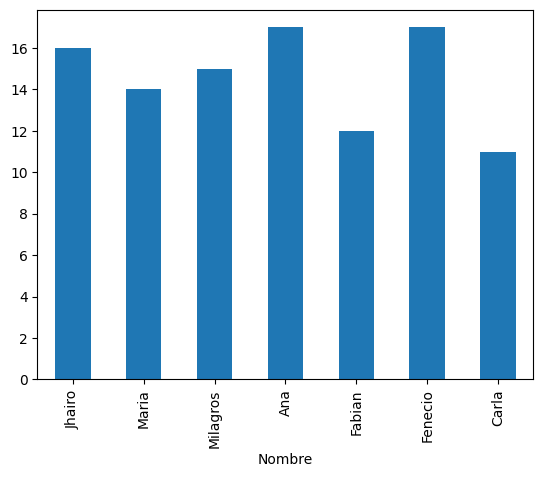

In [89]:
pandas_result = pandas_df_agent.run("Dame un grafico de barras de nombre y nota en el curso de letras")
print(pandas_result)

<Axes: xlabel='Nombre'>

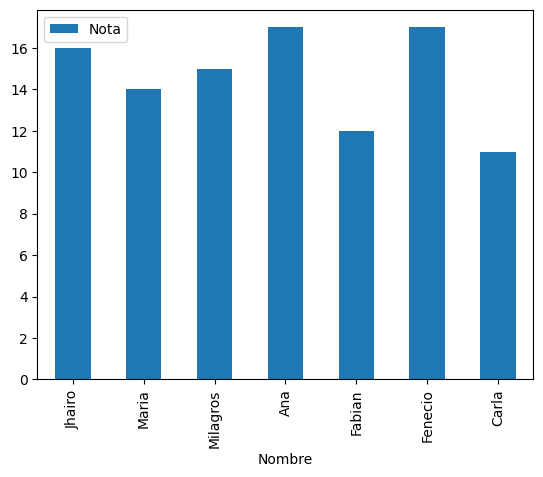

In [93]:
df_grafica = df[df["Curso"]=="Letras"]
df_grafica.plot.bar(x="Nombre", y="Nota")   

In [83]:
df[df["Nombre"]=="Jhairo"]

,Nombre,Nota,Curso
0,Jhairo,14,Matematica
7,Jhairo,16,Letras
